[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1gQOdL-jJSgp6JM48hI69D5BW8L-aho5v?usp=share_link)

In [ ]:
!pip install keras-flops
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.python.ops.math_ops import truediv
from keras_flops import get_flops
import warnings
warnings.filterwarnings('ignore')

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

#Data Loading

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

#Teacher

##Model Setup

In [3]:
def teacher_initial():
# Build CNN teacher.
  cnn_model = tf.keras.Sequential()
  cnn_model.add(layers.Conv2D(32, 3, (1, 1), activation='relu', input_shape=(28, 28, 1)))
  cnn_model.add(layers.MaxPooling2D((2, 2), strides=1))
  cnn_model.add(layers.Conv2D(64, 3, (1, 1), activation='relu'))
  cnn_model.add(layers.MaxPooling2D((2, 2), strides=2))
  cnn_model.add(layers.Flatten())
  cnn_model.add(layers.Dropout(0.5))
  cnn_model.add(layers.Dense(128, activation='relu'))
  cnn_model.add(layers.Dropout(0.5))
  cnn_model.add(layers.Dense(10))
  
  return cnn_model

In [4]:
teacher_model = teacher_initial()
teacher_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dropout (Dropout)           (None, 7744)              0

##Loss Function

In [5]:
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = teacher_model(images, training=True)

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits))

  return cross_entropy_loss_value

#Student

##Model Setup

In [28]:
def student_initial():
# Build fully connected student.
  fc_model = tf.keras.Sequential()
  fc_model.add(tf.keras.Input(shape=(28, 28, 1)))
  fc_model.add(layers.Flatten())
  fc_model.add(layers.Dense(784, activation='relu'))
  #fc_model.add(layers.Dense(784, activation='relu'))
  fc_model.add(layers.Dense(10))

  return fc_model

In [29]:
student_model = student_initial()
student_model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_37 (Flatten)        (None, 784)               0         
                                                                 
 dense_110 (Dense)           (None, 784)               615440    
                                                                 
 dense_111 (Dense)           (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


##Loss Function

In [21]:
# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 32. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
  
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = student_model(images, training=True)


  teacher_subclass_logits = teacher_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)


  hard_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))


  return (ALPHA * distillation_loss_value + (1- ALPHA) * hard_loss_value)

#Helper Function

In [15]:
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      a = compute_num_correct(model, images, labels)
      num_correct += a[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))

def student_loss_changeT(images, labels, T, alpha=0.5):
  student_subclass_logits = student_model(images, training=True)
  teacher_subclass_logits = teacher_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, T)
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))

  return (alpha * distillation_loss_value + (1- alpha) * cross_entropy_loss_value)

def student_test_acc(model, compute_loss_fn, T, alpha=0.5):
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  test_accuracy = []

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    #print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(images, labels, T, alpha=0.5)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      a = compute_num_correct(model, images, labels)
      num_correct += a[0]
    test_accuracy.append(num_correct / num_total * 100)
  return test_accuracy

def student_loss_changealpha(images, labels,  alpha):
  student_subclass_logits = student_model(images, training=True)
  teacher_subclass_logits = teacher_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, 4)
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))

  return (alpha * distillation_loss_value + (1- alpha) * cross_entropy_loss_value)

def student_test_acc_change(model, compute_loss_fn, T, alpha=0.5):
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  test_accuracy = []

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    #print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(images, labels, alpha)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      a = compute_num_correct(model, images, labels)
      num_correct += a[0]
    test_accuracy.append(num_correct / num_total * 100)
  return test_accuracy

#Training Process

##Train Teacher

In [10]:
train_and_evaluate(teacher_model, compute_teacher_loss)

Epoch 1: Class_accuracy: 98.04%
Epoch 2: Class_accuracy: 98.50%
Epoch 3: Class_accuracy: 98.88%
Epoch 4: Class_accuracy: 98.91%
Epoch 5: Class_accuracy: 99.00%
Epoch 6: Class_accuracy: 99.02%
Epoch 7: Class_accuracy: 99.11%
Epoch 8: Class_accuracy: 99.15%
Epoch 9: Class_accuracy: 99.16%
Epoch 10: Class_accuracy: 99.15%
Epoch 11: Class_accuracy: 99.14%
Epoch 12: Class_accuracy: 99.19%


##Train Student from Scratch

In [11]:
student_model = student_initial()

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """

  student_subclass_logits = student_model(images, training=True)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits) 
  
  return cross_entropy_loss


train_and_evaluate(student_model, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.82%
Epoch 2: Class_accuracy: 97.23%
Epoch 3: Class_accuracy: 97.86%
Epoch 4: Class_accuracy: 98.11%
Epoch 5: Class_accuracy: 97.96%
Epoch 6: Class_accuracy: 98.20%
Epoch 7: Class_accuracy: 97.99%
Epoch 8: Class_accuracy: 98.05%
Epoch 9: Class_accuracy: 97.93%
Epoch 10: Class_accuracy: 98.18%
Epoch 11: Class_accuracy: 97.63%
Epoch 12: Class_accuracy: 98.21%


##Distill knowledge from Teacher to Student

In [13]:
student_model = student_initial()
train_and_evaluate(student_model, compute_student_loss)

Epoch 1: Class_accuracy: 96.53%
Epoch 2: Class_accuracy: 97.81%
Epoch 3: Class_accuracy: 98.10%
Epoch 4: Class_accuracy: 98.42%
Epoch 5: Class_accuracy: 98.51%
Epoch 6: Class_accuracy: 98.65%
Epoch 7: Class_accuracy: 98.64%
Epoch 8: Class_accuracy: 98.61%
Epoch 9: Class_accuracy: 98.65%
Epoch 10: Class_accuracy: 98.64%
Epoch 11: Class_accuracy: 98.70%
Epoch 12: Class_accuracy: 98.65%


#Hyperparameters Tuning

1 Temperature done
2 Temperature done
4 Temperature done
8 Temperature done
16 Temperature done
32 Temperature done
64 Temperature done


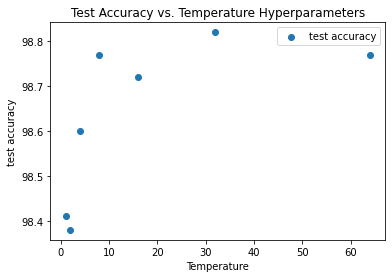

[<tf.Tensor: shape=(), dtype=float32, numpy=98.409996>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.38>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.6>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.77>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.72>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.82>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.77>]

In [18]:
T = [1, 2, 4, 8, 16, 32, 64]
test_accuracy_list = []
for temp in T:
  student_model = student_initial()
  test_accuracy = student_test_acc(student_model, student_loss_changeT, T = temp, alpha=0.5)
  print(temp,'Temperature done')
  test_accuracy_list.append(test_accuracy[-1])
plt.scatter(T, test_accuracy_list, label='test accuracy')
plt.xlabel("Temperature")
plt.ylabel("test accuracy")
plt.title("Test Accuracy vs. Temperature Hyperparameters")
plt.legend()
plt.show()
test_accuracy_list

0.1 Alpha done
0.2 Alpha done
0.3 Alpha done
0.4 Alpha done
0.5 Alpha done
0.6 Alpha done
0.7 Alpha done
0.8 Alpha done
0.9 Alpha done


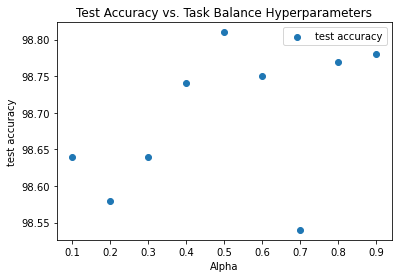

[<tf.Tensor: shape=(), dtype=float32, numpy=98.64>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.58>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.64>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.74>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.81>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.75>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.54>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.77>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.78>]

In [20]:
alpha = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
test_accuracy_list = []
for a in alpha:
  student_model = student_initial()
  test_accuracy = student_test_acc_change(student_model, student_loss_changealpha, T = 32, alpha=a)
  print(a,'Alpha done')
  test_accuracy_list.append(test_accuracy[-1])
plt.scatter(alpha, test_accuracy_list, label='test accuracy')
plt.xlabel("Alpha")
plt.ylabel("test accuracy")
plt.title("Test Accuracy vs. Task Balance Hyperparameters")
plt.legend()
plt.show()
test_accuracy_list

In [22]:
student_model = student_initial()
train_and_evaluate(student_model, compute_student_loss)

Epoch 1: Class_accuracy: 96.58%
Epoch 2: Class_accuracy: 97.75%
Epoch 3: Class_accuracy: 98.00%
Epoch 4: Class_accuracy: 98.40%
Epoch 5: Class_accuracy: 98.49%
Epoch 6: Class_accuracy: 98.49%
Epoch 7: Class_accuracy: 98.62%
Epoch 8: Class_accuracy: 98.74%
Epoch 9: Class_accuracy: 98.67%
Epoch 10: Class_accuracy: 98.68%
Epoch 11: Class_accuracy: 98.74%
Epoch 12: Class_accuracy: 98.75%


#Results

In [27]:
cnnflops = get_flops(teacher_model)
fcflops = get_flops(student_model)
print('flops for teacher teacher model is',cnnflops)
print('flops for student student model is',fcflops)

flops for teacher teacher model is 22042058
flops for student student model is 2475882


|                                | Test Accuracy | Number of Param. | FLOPs    |
|--------------------------------|---------------|------------------|----------|
| Teacher Model                  | 99.19%        | 1,011,466        | 2.2*10^7 |
| Student Trained from Scratch   | 98.21%        | 623,290          | 2.5*10^6 |
| Student distilled from Teacher | 98.75%        | 623,290          | 2.5*10^6 |